In [1]:
#Libraries
import pandas as pd
import numpy as np
import random
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn import svm
import copy
import matplotlib.pyplot as plt

In [9]:
#Dataset Read
dataset_df = pd.read_csv('data/jm1.csv')
dataset_df = dataset_df[~dataset_df.uniq_Op.str.contains("\?")]
df_mu = copy.deepcopy(dataset_df)
df_mu.reset_index(inplace = True,drop = True)

In [4]:
#Mutator Function:
def seen(dataset,parent_candidate):
    size = dataset.shape[0]
    candidate_1 = dataset.loc[random.randint(0,size-1)]
    while candidate_1.equals(parent_candidate):
        candidate_1 = dataset.loc[random.randint(0,size-1)]
    candidate_2 = dataset.loc[random.randint(0,size-1)]
    while candidate_2.equals(parent_candidate) or candidate_1.equals(candidate_2):
        candidate_2 = dataset.loc[random.randint(0,size-1)]
    return parent_candidate,candidate_1,candidate_2
    
def select_candiate(dataset):
    size = dataset.shape[0]
    parent_candidate = dataset.loc[random.randint(0,size-1)]
    return seen(dataset,parent_candidate)

def data_mutator(dataset, f,cr,size):
    dataset.reset_index(inplace = True,drop = True)
    new_candidate = pd.DataFrame()
    dataset_columns = dataset.columns.values
    response_attribute = dataset_columns[len(dataset_columns)-1]
    for i in range(size):
        parent_candidate, child_candidate_1, child_candidate_2 = select_candiate(dataset)
        for key,value in parent_candidate.items():
            if key != response_attribute:
                if isinstance(parent_candidate[key], bool):
                    new_candidate.loc[i,key] = parent_candidate[key] if cr < random.random() else not parent_candidate[key]
                elif isinstance(parent_candidate[key], str):
                    new_candidate.loc[i,key] = random.choice([parent_candidate[key],child_candidate_1[key],child_candidate_2[key]])
                elif isinstance(parent_candidate[key], list):
                    temp_lst = []
                    for i, each in enumerate(parent_candidate[key]):
                          temp_lst.append(parent_candidate[key][i] if cr < random.random() else
                                          int(parent_candidate[key][i] +
                                              f * (child_candidate_1[key][i] - child_candidate_2[key][i])))
                    new_candidate.loc[i,key] = temp_lst
                else:
                    new_candidate.loc[i,key] = parent_candidate[key] if cr < random.random() else (
                      abs(parent_candidate[key] + f * (child_candidate_1[key] - child_candidate_2[key])))
            else:
                new_candidate.loc[i,key] = parent_candidate[key]
    return new_candidate

In [5]:
# Score generator
class counter():
    
    def __init__(self, before, after, indx):
        self.indx = indx
        self.actual = before
        self.predicted = after
        self.TP, self.TN, self.FP, self.FN = 0, 0, 0, 0
        for a, b in zip(self.actual, self.predicted):
            if a == indx and b == indx:
                self.TP += 1
            elif a == b and a != indx:
                self.TN += 1
            elif a != indx and b == indx:
                self.FP += 1
            elif a == indx and b != indx:
                self.FN += 1
            elif a != indx and b != indx:
                pass


    def stats(self):
        pd, pf, prec, F, G, acc = 0, 0, 0, 0, 0,0
        if self.TP + self.FN:
            pd = self.TP / (self.TP + self.FN)
        if self.FP+self.TN:
            pf = self.FP/(self.FP+self.TN)
        if self.TP+self.FP:
            prec = self.TP/(self.TP+self.FP)
        if self.TP+self.FP+self.TN+self.TP:
            acc = (self.TP +self.TN)/(self.TP+self.TN+self.FP+self.FN)
        if pd+prec:
            F = 2*pd*prec/(pd+prec)
        if pd+(1-pf):
            G = 2*pd*(1-pf)/(pd+1-pf)
        return pd, pf,prec,acc,F,G



class ABCD():
    "Statistics Stuff, confusion matrix, all that jazz..."

    def __init__(self, before, after):
        self.actual = before
        self.predicted = after

    def __call__(self):
        uniques = set(self.actual)
        for u in list(uniques):
            yield counter(self.actual, self.predicted, indx=u)

# Calculating Macro goal
def calculate_score_macro(confusion_matrix_all_class):
    tp, fn, fp, tn = 0, 0, 0, 0
    avg_precision,avg_recall = 0,0
    precision,recall = [],[]
    for each in confusion_matrix_all_class:
        tp = each.TP
        fn = each.FN
        fp = each.FP
        tn = each.FP
        precision.append(float(tp)/float((tp+fp)))
        recall.append(float(tp)/float((tp+fn)))
    for i in range(len(precision)):
        avg_precision += precision[i]
        avg_recall += recall[i]
    avg_precision = avg_precision/len(precision)
    avg_recall = avg_recall/len(recall)
    avg_f1 = 2*(avg_recall*avg_precision)/(avg_recall+avg_precision)
    return avg_precision, avg_recall, avg_f1

# Calculate Micro goal
def calculate_score_micro(confusion_matrix_all_class):
    tp, fn, fp, tn = 0, 0, 0, 0
    avg_precision,avg_recall = 0,0
    precision,recall = [],[]
    for each in confusion_matrix_all_class:
        tp += each.TP
        fn += each.FN
        fp += each.FP
        tn += each.FP
    precision = (float(tp)/float((tp+fp)))
    recall = (float(tp)/float((tp+fn)))
    f1 = 2*(recall*precision)/(recall+precision)
    return precision, recall, f1

# Calculate Weighted goal
def calculate_score_weighted(confusion_matrix_all_class,mutated_test_y):
    total_test_point = len(mutated_test_y)
    uniques = list(set(mutated_test_y))
    tp, fn, fp, tn = 0, 0, 0, 0
    avg_precision,avg_recall = 0,0
    precision,recall = [],[]
    for each in confusion_matrix_all_class:
        tp = each.TP
        fn = each.FN
        fp = each.FP
        tn = each.FP
        if(tp+fp > 0):
            precision.append(float(tp)/float((tp+fp)))
        if(tp+fn > 0):
            recall.append(float(tp)/float((tp+fn)))
    for i in range(len(uniques)):
        avg_precision += precision[i]*(mutated_test_y.count(uniques[i]))
        avg_recall += recall[i]*(mutated_test_y.count(uniques[i]))
    avg_precision = avg_precision/total_test_point
    avg_recall = avg_recall/total_test_point
    avg_f1 = 2*(avg_recall*avg_precision)/(avg_recall+avg_precision)
    return avg_precision, avg_recall, avg_f1

In [ ]:
# Experimental Results Changing cross over probability only(mutating test set)
repeats = 5
fold = 5
data_x = dataset_df.drop(['defects'], axis = 1, inplace = False)
data_y = dataset_df.defects
clf = MultinomialNB()
cr = [0.4,0.5,0.6,0.7,0.8]
precision_l, recall_l, f1_l = [],[],[]
for i in range(repeats):  # repeat n times here
    kf = StratifiedKFold(fold, shuffle=True)
    avg_precision, avg_recall, avg_f1 = 0,0,0
    print("Iteration:", i, "with cross over probability:",cr[i])
    for train_index, test_index in kf.split(data_x,data_y):
        print("training on split")
        train_data_x = data_x.iloc[train_index]
        train_data_y = data_y.iloc[train_index]
        test_data_x = data_x.iloc[test_index]
        test_data_y = data_y.iloc[test_index]
        test = pd.concat([test_data_x,test_data_y],axis = 1) 
        modified_dataset = data_mutator(test,0.7,cr[i],test.shape[0]) #mutating test set
        mutated_test_x = modified_dataset.drop(['defects'], axis = 1, inplace = False)
        mutated_test_y = modified_dataset.defects.tolist()
        clf.fit(train_data_x,train_data_y)
        predicted = clf.predict(mutated_test_x)
        abcd = ABCD(mutated_test_y, predicted)
        confusion_matrix_all_class = [each for each in abcd()]
        precision, recall, f1 = calculate_score_weighted(confusion_matrix_all_class,mutated_test_y)
        avg_precision += precision
        avg_recall += recall
        avg_f1 += f1
    avg_precision = avg_precision/repeats
    avg_recall = avg_recall/repeats
    avg_f1 = avg_f1/repeats
    precision_l.append(avg_precision)
    recall_l.append(avg_recall)
    f1_l.append(avg_f1)

# Drawing plot for F1 Score
plt.plot(f1_l)

In [ ]:
# Experimental Results Changing cross over probability only(mutating train set)
repeats = 5
fold = 5
data_x = dataset_df.drop(['defects'], axis = 1, inplace = False)
data_y = dataset_df.defects
clf = MultinomialNB()
cr = [0.4,0.5,0.6,0.7,0.8]
precision_l, recall_l, f1_l = [],[],[]
for i in range(repeats):  # repeat n times here
    kf = StratifiedKFold(fold, shuffle=True)
    avg_precision, avg_recall, avg_f1 = 0,0,0
    print("Iteration:", i, "with cross over probability:",cr[i])
    for train_index, test_index in kf.split(data_x,data_y):
        print("training on split")
        train_data_x = data_x.iloc[train_index]
        train_data_y = data_y.iloc[train_index]
        test_data_x = data_x.iloc[test_index]
        test_data_y = data_y.iloc[test_index]
        train = pd.concat([test_data_x,test_data_y],axis = 1) 
        modified_dataset = data_mutator(train,0.7,cr[i],train.shape[0]) #mutating train set
        mutated_train_x = modified_dataset.drop(['defects'], axis = 1, inplace = False)
        mutated_train_y = modified_dataset.defects.tolist()
        clf.fit(mutated_train_x,mutated_train_y)
        predicted = clf.predict(test_data_x)
        abcd = ABCD(test_data_y, predicted)
        confusion_matrix_all_class = [each for each in abcd()]
        precision, recall, f1 = calculate_score_weighted(confusion_matrix_all_class,list(test_data_y.values))
        avg_precision += precision
        avg_recall += recall
        avg_f1 += f1
    avg_precision = avg_precision/repeats
    avg_recall = avg_recall/repeats
    avg_f1 = avg_f1/repeats
    precision_l.append(avg_precision)
    recall_l.append(avg_recall)
    f1_l.append(avg_f1)
        
# Drawing plot for F1 Score
plt.plot(f1_l)

testing with crossover frequency: 0.0
testing with crossover frequency: 0.2
testing with crossover frequency: 0.4
testing with crossover frequency: 0.6
testing with crossover frequency: 0.8
testing with crossover frequency: 1.0
testing with crossover frequency: 1.2
testing with crossover frequency: 1.4
testing with crossover frequency: 1.6
testing with crossover frequency: 1.8
testing with crossover frequency: 2.0
testing with crossover frequency: 2.2
testing with crossover frequency: 2.4
testing with crossover frequency: 2.6
testing with crossover frequency: 2.8
testing with crossover frequency: 3.0
testing with crossover frequency: 3.2
testing with crossover frequency: 3.4
testing with crossover frequency: 3.6
testing with crossover frequency: 3.8


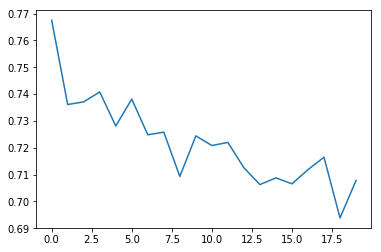

In [16]:
# Testing with changing mutation rate
precision_l, recall_l, f1_l = [],[],[]
data_x = dataset_df.drop(['defects'], axis = 1, inplace = False)
data_y = dataset_df.defects
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
clf = MultinomialNB()
clf.fit(train_x,train_y)
test_data = pd.concat([test_x,test_y],axis = 1) 
for i in range(20):
    print('testing with crossover frequency:',i/20)
    new_data = data_mutator(test_data,i/20,0.75,test_data.shape[0]) #mutating train set
    mutated_test_y = new_data['defects'].values
    mutated_test_x = new_data.drop(['defects'], axis = 1, inplace = False)
    predicted = clf.predict(mutated_test_x)
    abcd = ABCD(mutated_test_y, predicted)
    confusion_matrix_all_class = [each for each in abcd()]
    precision, recall, f1 = calculate_score_weighted(confusion_matrix_all_class,list(mutated_test_y))
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)


# Drawing plot for F1 Score
plt.plot(f1_l)    

testing with crossover frequency: 0.0
testing with crossover frequency: 0.05
testing with crossover frequency: 0.1
testing with crossover frequency: 0.15
testing with crossover frequency: 0.2
testing with crossover frequency: 0.25
testing with crossover frequency: 0.3
testing with crossover frequency: 0.35
testing with crossover frequency: 0.4
testing with crossover frequency: 0.45
testing with crossover frequency: 0.5
testing with crossover frequency: 0.55
testing with crossover frequency: 0.6
testing with crossover frequency: 0.65
testing with crossover frequency: 0.7
testing with crossover frequency: 0.75
testing with crossover frequency: 0.8
testing with crossover frequency: 0.85
testing with crossover frequency: 0.9
testing with crossover frequency: 0.95


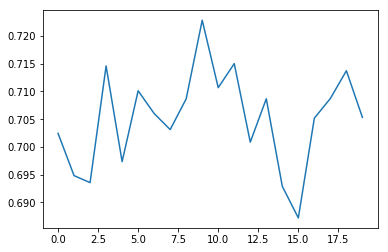

In [17]:
# Testing with changing mutation rate
precision_l, recall_l, f1_l = [],[],[]
data_x = dataset_df.drop(['defects'], axis = 1, inplace = False)
data_y = dataset_df.defects
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
clf = MultinomialNB()
clf.fit(train_x,train_y)
test_data = pd.concat([test_x,test_y],axis = 1) 
for i in range(20):
    print('testing with crossover frequency:',i/20)
    new_data = data_mutator(test_data,i/20,0.75,test_data.shape[0]) #mutating test set
    mutated_test_y = new_data['defects'].values
    mutated_test_x = new_data.drop(['defects'], axis = 1, inplace = False)
    predicted = clf.predict(mutated_test_x)
    abcd = ABCD(mutated_test_y, predicted)
    confusion_matrix_all_class = [each for each in abcd()]
    precision, recall, f1 = calculate_score_weighted(confusion_matrix_all_class,list(mutated_test_y))
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)


# Drawing plot for F1 Score
plt.plot(f1_l) 

testing with crossover frequency: 0.0
testing with crossover frequency: 0.2
testing with crossover frequency: 0.4
testing with crossover frequency: 0.6
testing with crossover frequency: 0.8


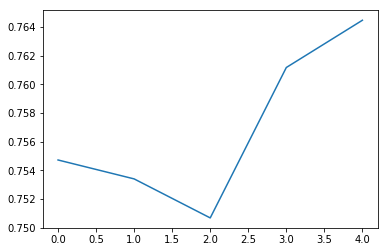

In [20]:
# Training with changing crossover frequency
precision_l, recall_l, f1_l = [],[],[]
data_x = dataset_df.drop(['defects'], axis = 1, inplace = False)
data_y = dataset_df.defects
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
clf = MultinomialNB()
clf.fit(train_x,train_y)
train_data = pd.concat([train_x,train_y],axis = 1) 
for i in range(5):
    print('testing with crossover frequency:',i/5)
    new_data = data_mutator(train_data,i/5,0.75,train_data.shape[0]) #mutating train set
    mutated_train_y = new_data['defects'].values.tolist()
    mutated_train_x = new_data.drop(['defects'], axis = 1, inplace = False)
    clf.fit(mutated_train_x,mutated_train_y)
    predicted = clf.predict(test_x)
    abcd = ABCD(test_y, predicted)
    confusion_matrix_all_class = [each for each in abcd()]
    precision, recall, f1 = calculate_score_weighted(confusion_matrix_all_class,list(test_y))
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)


# Drawing plot for F1 Score
plt.plot(f1_l) 

testing with crossover frequency: 0.0
testing with crossover frequency: 0.05
testing with crossover frequency: 0.1
testing with crossover frequency: 0.15
testing with crossover frequency: 0.2
testing with crossover frequency: 0.25
testing with crossover frequency: 0.3
testing with crossover frequency: 0.35
testing with crossover frequency: 0.4
testing with crossover frequency: 0.45
testing with crossover frequency: 0.5
testing with crossover frequency: 0.55
testing with crossover frequency: 0.6
testing with crossover frequency: 0.65
testing with crossover frequency: 0.7
testing with crossover frequency: 0.75
testing with crossover frequency: 0.8
testing with crossover frequency: 0.85
testing with crossover frequency: 0.9
testing with crossover frequency: 0.95


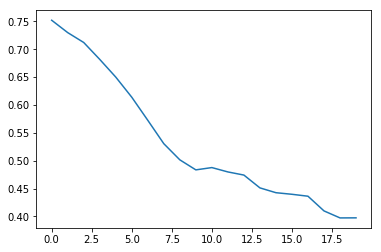

In [10]:
# Testing with changing mutation rate ## Working
precision_l, recall_l, f1_l = [],[],[]
data_x = dataset_df.drop(['defects'], axis = 1, inplace = False)
data_y = dataset_df.defects
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
clf = MultinomialNB()
clf.fit(train_x,train_y)
test_data = pd.concat([test_x,test_y],axis = 1) 
for i in range(20):
    print('testing with crossover frequency:',i/20)
    new_data = data_mutator(test_data,i/20,0.75,test_data.shape[0]) #mutating train set
    mutated_test_y = new_data['defects'].values
    mutated_test_x = new_data.drop(['defects'], axis = 1, inplace = False)
    predicted = clf.predict(mutated_test_x)
    abcd = ABCD(mutated_test_y, predicted)
    confusion_matrix_all_class = [each for each in abcd()]
    precision, recall, f1 = calculate_score_weighted(confusion_matrix_all_class,list(mutated_test_y))
    precision_l.append(precision)
    recall_l.append(recall)
    f1_l.append(f1)
    test_data = new_data


# Drawing plot for F1 Score
plt.plot(f1_l)    

testing with crossover frequency: 0.0
testing with crossover frequency: 0.05
testing with crossover frequency: 0.1
testing with crossover frequency: 0.15
testing with crossover frequency: 0.2
testing with crossover frequency: 0.25
testing with crossover frequency: 0.3
testing with crossover frequency: 0.35
testing with crossover frequency: 0.4
testing with crossover frequency: 0.45
testing with crossover frequency: 0.5
testing with crossover frequency: 0.55
testing with crossover frequency: 0.6
testing with crossover frequency: 0.65
testing with crossover frequency: 0.7
testing with crossover frequency: 0.75
testing with crossover frequency: 0.8
testing with crossover frequency: 0.85
testing with crossover frequency: 0.9
testing with crossover frequency: 0.95
testing with crossover frequency: 0.0
testing with crossover frequency: 0.05
testing with crossover frequency: 0.1
testing with crossover frequency: 0.15
testing with crossover frequency: 0.2
testing with crossover frequency: 0.25

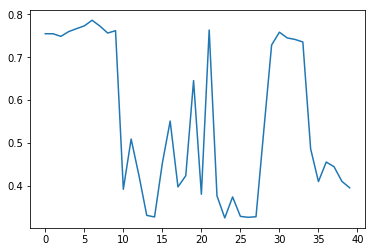

In [28]:
# Training with changing crossover frequency
precision_l, recall_l, f1_l = [],[],[]
data_x = dataset_df.drop(['defects'], axis = 1, inplace = False)
data_y = dataset_df.defects
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
clf = MultinomialNB()
clf.fit(train_x,train_y)
train_data = pd.concat([train_x,train_y],axis = 1) 
for j in range(2):
    for i in range(20):
        print('testing with crossover frequency:',i/20)
        new_data = data_mutator(train_data,i/20,0.75,train_data.shape[0]) #mutating train set
        mutated_train_y = new_data['defects'].values.tolist()
        mutated_train_x = new_data.drop(['defects'], axis = 1, inplace = False)
        clf.fit(mutated_train_x,mutated_train_y)
        predicted = clf.predict(test_x)
        abcd = ABCD(test_y, predicted)
        confusion_matrix_all_class = [each for each in abcd()]
        precision, recall, f1 = calculate_score_weighted(confusion_matrix_all_class,list(test_y))
        precision_l.append(precision)
        recall_l.append(recall)
        f1_l.append(f1)
        train_data = new_data

# Drawing plot for F1 Score
plt.plot(f1_l) 